# 2.2.3 Feature Engineering

What we've seen so far is how to load data into a Pandas data frame and perform some initial exploration and sanity checks to verify it looks how we expect. Following that, it's still unlikely the data will be ready to be fed straight into an analysis or model so we must mould it to fit our needs.

This is what we'll focus on for most of the rest of this module. In the literature you'll find it referred to as "preprocessing", "wrangling", "feature engineering" and many other terms, which all cover some aspect of curating and manipulating the raw source data. In this section we focus on numerical data, but we discuss approaches for other types of data in [Section 2.2.4](2-02-04-DataManipulation).

Here we'll be using data from the Anthropometric Survey of US Army Personnel ([ANSUR 2](https://www.openlab.psu.edu/ansur2/)), which includes comprehensive body shape and size measurements for people in the US army that were taken in 2012 and released publicly in 2017. There's data on both males and females, we'll use the female data here:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/ANSUR_II_FEMALE_Public.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1986 entries, 0 to 1985
Columns: 108 entries, SubjectId to WritingPreference
dtypes: int64(99), object(9)
memory usage: 1.6+ MB


,SubjectId,abdominalextensiondepthsitting,acromialheight,acromionradialelength,anklecircumference,axillaheight,balloffootcircumference,balloffootlength,biacromialbreadth,bicepscircumferenceflexed,...,Branch,PrimaryMOS,SubjectsBirthLocation,SubjectNumericRace,Ethnicity,DODRace,Age,Heightin,Weightlbs,WritingPreference
0,10037,231,1282,301,204,1180,222,177,373,315,...,Combat Support,92Y,Germany,2,NaN,2,26,61,142,Right hand
1,10038,194,1379,320,207,1292,225,178,372,272,...,Combat Service Support,25U,California,3,Mexican,3,21,64,120,Right hand
2,10042,183,1369,329,233,1271,237,196,397,300,...,Combat Service Support,35D,Texas,1,NaN,1,23,68,147,Right hand
3,10043,261,1356,306,214,1250,240,188,384,364,...,Combat Service Support,25U,District of Columbia,8,Caribbean Islander,2,22,66,175,Right hand
4,10051,309,1303,308,214,1210,217,182,378,320,...,Combat Arms,42A,Texas,1,NaN,1,45,63,195,Right hand


It's also an interesting example of data documentation, with over 250 pages of notes on how the measurements were taken in its [Measurer’s Handbook](http://tools.openlab.psu.edu/publicData/ANSURII-TR11-017.pdf), for example.


## Scaling & Transforming Features

It's common to need to map the original feature values in a dataset on to a different scale, either to improve their "human" interpretability (for yourself or others you're presenting results to), or what we could call their "model interpretability" (converting values to be more compatible with the design and assumptions of a particular algorithm). Here we show how some frequently used operations can be performed with Pandas.

### Converting Units

Despite the name, the `weightkg` column in the ANSUR 2 dataset is in units of 100 grams (tenths of a kilogram):

In [3]:
df["weightkg"].describe()

count    1986.000000
mean      677.582075
std       109.846458
min       358.000000
25%       601.000000
50%       668.000000
75%       745.750000
max      1196.000000
Name: weightkg, dtype: float64

And the `stature` (the person's height) column is in millimetres:

In [4]:
df["stature"].describe()

count    1986.000000
mean     1628.473313
std        64.199512
min      1409.000000
25%      1586.250000
50%      1626.000000
75%      1672.000000
max      1829.000000
Name: stature, dtype: float64

For interpreting the data ourselves and presenting it to others it's helpful to have values on scales we're familiar with. It's quick to perform simple mathematical operations on columns with Pandas - let's convert the `weightkg` column to actually be in kilograms, and the `stature` column to be in metres:

In [5]:
df["weightkg"] = df["weightkg"] / 10  # 100g -> kg
print("Median weight:", df["weightkg"].median(), "kg")

df["stature"] = df["stature"] / 1000  # mm -> metres
print("Median height:", df["stature"].median(), "m")

Median weight: 66.8 kg
Median height: 1.626 m


These look more familiar (at least if you're used to using the metric system!) We can also see that women in the army are lighter and taller on average compared to the general population ([73.1 kg median weight and 1.613 metres median height](https://www.cdc.gov/nchs/data/series/sr_03/sr03-046-508.pdf)), so we'd need to be careful not to generalise results from this data to the USA as a whole.

### Normalisation

We'll often have features that are on different scales (magnitudes). For example the axilla (armpit) height and ankle circumference in this dataset:

In [6]:
def get_stats(series):
    """Get a formatted message with the minimum, maximum, mean, and
    standard deviation of a pandas series"""
    return "min = {:.2f}, max = {:.2f}, mean = {:.2f}, std = {:.2f}".format(
        series.min(),
        series.max(),
        series.mean(),
        series.std(),
    )


columns = ["anklecircumference", "axillaheight"]

print("Original:")
for col in columns:
    print(col, ":", get_stats(df[col]))


Original:
anklecircumference : min = 170.00, max = 275.00, mean = 215.74, std = 14.89
axillaheight : min = 1038.00, max = 1419.00, mean = 1239.03, std = 55.80


The maximum axilla height is 1419 mm, and the biggest ankle only 275 mm in circumference. Having features with different magnitudes can have unintended consequences for some algorithms, such as those that use a metric of similarity between data points (like [k-nearest neighbours](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)), for example. Say we wanted to compute how "similar" someone with the largest ankle circumference and axilla height was to the "average" person in those columns. Algorithms like these will often compute a metric like:

$$
(\mathrm{ankle}_{max} - \mathrm{ankle}_{mean})^2 + (\mathrm{axilla}_{max} - \mathrm{axilla}_{mean})^2 \\
(275.00 - 215.74)^2 + (1419.00 - 1239.03)^2 \\
59.26^2 + 179.97^2 \\
\simeq 3512 + 32389
$$

Note that the axilla height ends up contributing almost 10 times more to the similarity metric, but only because it's  a measurement of a larger distance. We probably intended differences in ankle size and armpit height to contribute equally.

One common way to solve this is to min-max scale, or "normalise" the data, as follows:

In [7]:
def norm_min_max(series):
    """Min-max scale a pandas series"""
    return (series - series.min()) / (series.max() - series.min())


print("Min-max scaled:")
for col in columns:
    df[col] = norm_min_max(df[col])
    print(col, ":", get_stats(df[col]))


Min-max scaled:
anklecircumference : min = 0.00, max = 1.00, mean = 0.44, std = 0.14
axillaheight : min = 0.00, max = 1.00, mean = 0.53, std = 0.15


With this scaling applied both columns have a minimum value of 0 and a maximum of 1, and so they become relative measurements of how close someone is to the largest value for each feature.

### Standardisation

Another popular scaling approach is to "standardise" the data, or transform it so the feature has a mean of zero and a standard deviation of one, which can be achieved by subtracting the original mean and dividing by the original standard deviation of the feature:

In [8]:
def standardize(series):
    """Standardise a pandas series to have zero mean and unit
    standard deviation"""
    return (series - series.mean()) / series.std()


columns = ["footlength", "earlength"]

print("Original:")
for col in columns:
    print(col, ":", get_stats(df[col]))

print("\nStandardised:")
for col in columns:
    df[col] = standardize(df[col])
    print(col, ":", get_stats(df[col]))


Original:
footlength : min = 198.00, max = 286.00, mean = 246.29, std = 12.44
earlength : min = 46.00, max = 74.00, mean = 59.36, std = 3.88

Standardised:
footlength : min = -3.88, max = 3.19, mean = -0.00, std = 1.00
earlength : min = -3.44, max = 3.77, mean = -0.00, std = 1.00


Note that although both columns have the same mean and standard deviation after the transformation, they have different minimum and maximum values. Alternatively, after _normalisation_ the features have the same minimum and maximum values but different means and standard deviations.

One key consequence of the different approaches is that standardisation preserves outliers (the range of the values is not restricted), whilst normalisation forces each feature to lie within the same range. Which is more appropriate depends on the use case(and you may want to try both and see which performs better).

### Transformation

Let's have a look at the distribution of ages in the ANSUR 2 data:

Text(0.5, 0, 'Age')

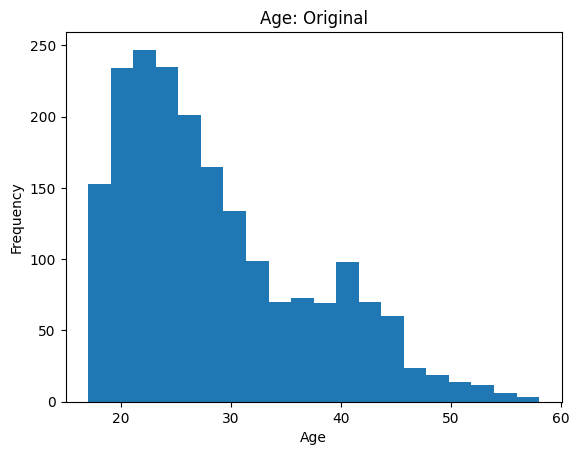

In [9]:
df["Age"].plot.hist(bins=20)
plt.title("Age: Original")
plt.xlabel("Age")

Plotting and visualisation is the focus of Module 3, so we won't discuss the details of how to create plots here.

We see the majority of people are young adults under 35, but there is a long tail of older personnel up to around 60 years old. Some statistical analyses and models make assumptions about the data being normally distributed, or otherwise may perform poorly when long tails/outliers are present. In these cases one option is to log transform the data:

Text(0.5, 0, 'log(Age)')

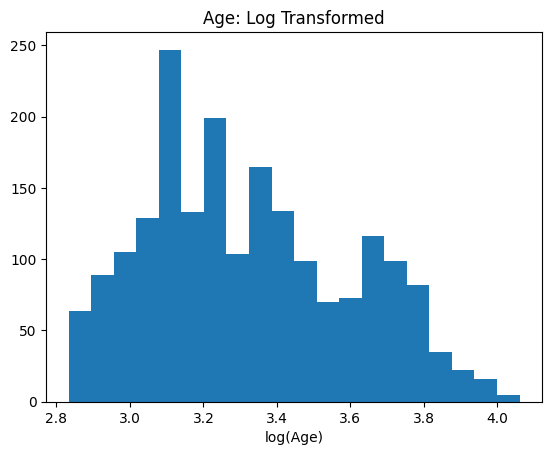

In [10]:
log_age = np.log(df["Age"])

plt.hist(log_age, bins=20)
plt.title("Age: Log Transformed")
plt.xlabel("log(Age)")

This has the effect of reducing the skewness of the distribution and making it "more normal". Whether this, or another transformation, is appropriate for your analysis is a nuanced topic beyond the scope of this course. [Here's a longer discussion](https://data.library.virginia.edu/interpreting-log-transformations-in-a-linear-model/) on the consequences of log transforming data. Another popular algorithm for improving the normality of data is the [Box-Cox transformation](https://www.itl.nist.gov/div898/handbook/eda/section3/eda336.htm).

## Creating New Features

Another common task is to use domain knowledge to create new features that may be of interest for an analysis, or could add predictive power to a model. For this dataset it may be useful to compute the body mass index of the army personnel, for example, the formula for which is:

$$
\textrm{BMI} = \frac{\textrm{weight}}{\textrm{height}^2}
$$

with weight in kilograms and height in metres. It's quick to do this with Pandas:

In [11]:
df["bmi"] = df["weightkg"] / df["stature"]**2
df["bmi"].describe()

count    1986.000000
mean       25.495970
std         3.491673
min        16.366156
25%        23.077535
50%        25.266752
75%        27.609363
max        40.778999
Name: bmi, dtype: float64

To apply an arbitrary function to a Pandas data frame you can also use [`apply`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html):

In [12]:
def calculate_bmi(person):
    """Calculate body mass index from  a person's data.
    Person is a pandas series which must include 'weightkg' and 'stature' in its index."""
    return person["weightkg"] / person["stature"] ** 2


df.apply(calculate_bmi, axis=1)

0       26.997041
1       19.262506
2       22.647148
3       28.378575
4       35.853259
          ...    
1981    29.234331
1982    27.558173
1983    28.193653
1984    24.201059
1985    22.652319
Length: 1986, dtype: float64

With `axis=1` the function will be applied to each row in the data frame, or with `axis=0` to each column.

`apply` works like using a `for` loop on the data, which means it doesn't benefit from the optimised vector operations `numpy` provides:

In [13]:
%%timeit

df.apply(calculate_bmi, axis=1)

19.5 ms ± 1.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%%timeit

df["weightkg"] / df["stature"]**2

126 µs ± 3.28 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


Using `apply` is almost two hundred times slower (the exact ratio will vary depending on your system), and for larger datasets or more complex functions this can add up to a lot of time! We cover ways to make Python code run faster in more detail in the "Programming for Speed" module of our [Research Software Engineering course](https://alan-turing-institute.github.io/rsd-engineeringcourse/html/index.html), but it's better to avoid using `apply` if you can.

As well as curating domain-specific features, another option is to generate many possible combinations of the original columns, and then perhaps select a subset of promising ones after further analysis (see feature selection below). The [`PolynomialFeatures`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures) class in the scikit-learn library generates features that are polynomial combinations of the original features (`weight`, `height`, `weight^2`, `height^2`, `weight * height`, ...), for example.

Which columns and functions to use and combine into new features is problem-specific and there's no one-size-fits-all solution.

## Binning

Binning is the process of converting a column of continuous values into a discrete set of categories, such as mapping a person's age to an age range (or age "bin"):

| Age  | Age Range | Bin Index |
| -- | -- | -- |
| 24 | 20-29 | 0 |
| 45 | 40-49 | 2 |
| 37 | 30-39 | 1 |
| 52 | 50-59 | 3 |
| 28 | 20-29 | 0 |
| 44 | 40-49 | 2 |

To incorporate the bins in an analysis we usually give them an ordered index from bins with the smallest values (0, meaning an age between 20-29 above) to the largest values (3, meaning an age between 50-59 above).

There are several scenarios where binning may be useful:

- To create domain-relevant categories relevant for your research question. You may be interested in differences between children, adults and the elderly, for example, rather than between specific ages.
- As a way of dealing with outliers. Biases caused by data with unusually large (or small) values may be mitigated be grouping extreme values in a single bin.
- In some cases using binned data could improve the performance of a model (it may help to reduce [overfitting](https://en.wikipedia.org/wiki/Overfitting), for example).

To show how binning works in Pandas we'll use the arm span data (`span` column) in ANSUR 2, which has this distribution:

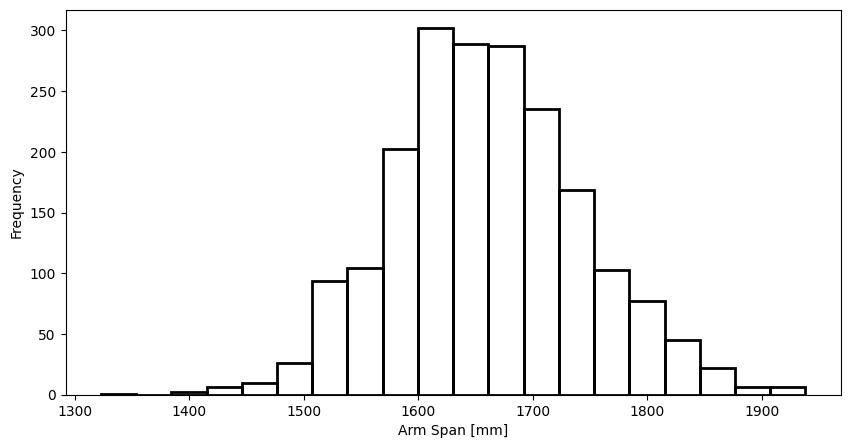

In [15]:
def plot_span_dist(bins=None):
    """
    Plot the distribution of arm span and show the location of bins, if given
    """
    plt.figure(figsize=(10, 5))
    df["span"].plot.hist(bins=20, edgecolor="k", facecolor="None", linewidth=2)
    if bins is not None:
        # add a vertical line at each bin edge
        [plt.axvline(edge, color="k", linestyle="--") for edge in bins]
        # add bin index labels
        [
            plt.annotate(
                f"Bin\n{i}",
                (edge + 5, 325),
                rotation=0,
                fontsize=14,
                annotation_clip=False,
            )
            for i, edge in enumerate(bins[:-1])
        ]
        # add shading for each bin width
        colors = ["r", "b", "g", "m", "y"]
        [
            plt.axvspan(bins[i], bins[i + 1], alpha=0.1, color=colors[i % len(colors)])
            for i in range(0, len(bins) - 1)
        ]
    plt.xlabel("Arm Span [mm]")
    
plot_span_dist()

Again, don't worry about the details of this plotting function for now, we'll be looking at that in Module 3.


Pandas provides a binning function [`pd.cut`](https://pandas.pydata.org/docs/reference/api/pandas.cut.html), which by default segments the data into a number of ***equal-width*** bins:

In [16]:
# The second argument, 5, is the number of bins to segment the data into.
# Setting 'retbins=True' returns an array of bin edges that we use for plotting below.
span_bins, bin_edges = pd.cut(df["span"], 5, retbins=True)
span_bins

0       (1569.0, 1692.0]
1       (1692.0, 1815.0]
2       (1692.0, 1815.0]
3       (1692.0, 1815.0]
4       (1692.0, 1815.0]
              ...       
1981    (1692.0, 1815.0]
1982    (1569.0, 1692.0]
1983    (1692.0, 1815.0]
1984    (1569.0, 1692.0]
1985    (1569.0, 1692.0]
Name: span, Length: 1986, dtype: category
Categories (5, interval[float64, right]): [(1322.385, 1446.0] < (1446.0, 1569.0] < (1569.0, 1692.0] < (1692.0, 1815.0] < (1815.0, 1938.0]]

This returns a Pandas series with a "category" data type (see [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) for more information). Each value in the data is assigned to the bin (or category) whose range encompasses it, with each bin labelled as `(minimum value, maximum value]` (which is a bin including values `minimum < x <= maximum`). The bins span all values from the minimum to the maximum arm span, and each bin has the same width:

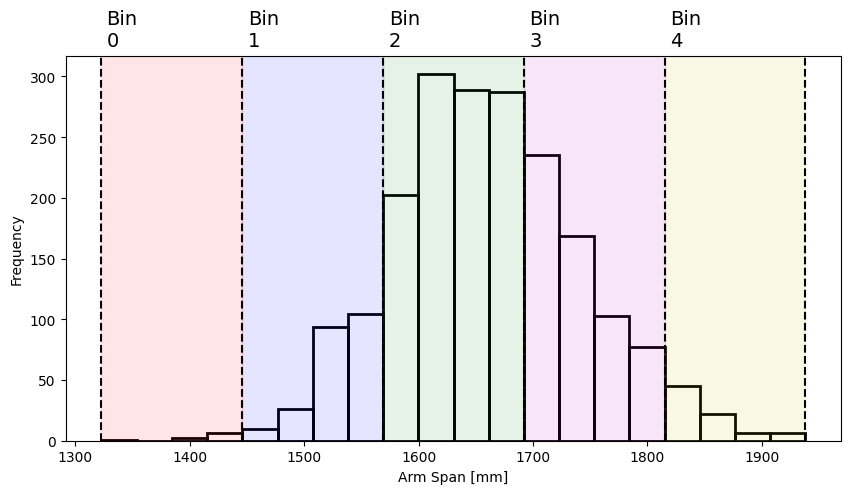

In [17]:
plot_span_dist(bin_edges)

Rather than the verbose bin label seen in the result from `pd.cut` above, you can also extract a bin index (ranked from smallest to largest) using the `.cat.codes` attribute:

In [18]:
span_bins.cat.codes

0       2
1       3
2       3
3       3
4       3
       ..
1981    3
1982    2
1983    3
1984    2
1985    2
Length: 1986, dtype: int8

We talk more about categorical data in [Section 2.2.4.3](2-02-04-03-CategoricalData). Pandas also provides an alternative binning function, [`pd.qcut`](https://pandas.pydata.org/docs/reference/api/pandas.qcut.html), which creates bins based on quantiles. In this case each bin contains approximately the same ***proportion*** of the data:

In [19]:
span_qbins, bin_edges = pd.qcut(df["span"], 5, retbins=True)
span_qbins.value_counts(sort=False)

(1322.999, 1591.0]    404
(1591.0, 1636.0]      396
(1636.0, 1678.0]      398
(1678.0, 1728.0]      391
(1728.0, 1938.0]      397
Name: span, dtype: int64

And to achieve this the bins must have different widths (being narrower in the central portion of the distribution):

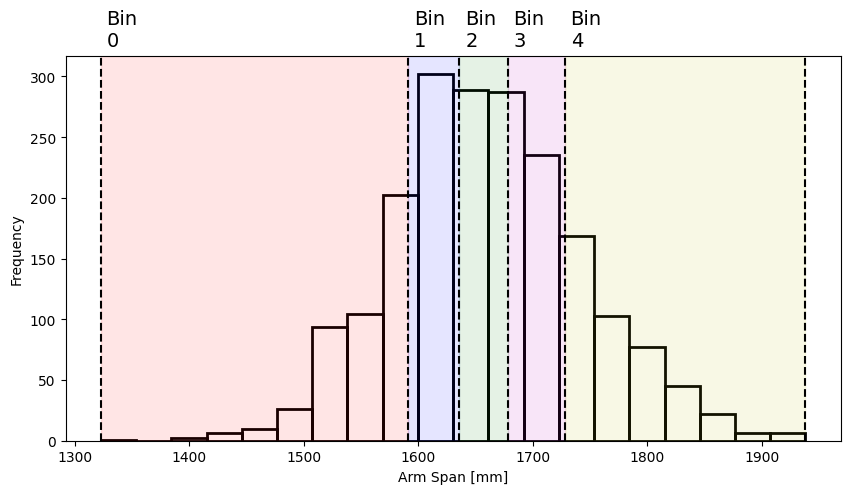

In [20]:
plot_span_dist(bin_edges)

You can customise `pd.cut` and `pd.qcut` to return bins of any width or bins for any quantile respectively by passing an array of bin edges as their second argument, for example `pd.cut(df["span"], [1300, 1600, 1700, 2000])`, see the [Pandas documentation](https://pandas.pydata.org/docs/reference/api/pandas.cut.html) for details.


## Feature Selection and Dimensionality Reduction

It's beyond the scope of what we cover here, but another important topic is the "curse of dimensionality", or what to do when we have many features (columns) relative to the number of samples (rows) in the dataset. [This blog post](http://blog.dominodatalab.com/the-curse-of-dimensionality) summarises how this can cause problems in some models.

Broadly speaking there are three techniques that can be used when this is a problem:

- **Feature selection:** Only include a subset of the available features in the model, keeping those that are the strongest predictors for the target variable. Scikit-learn has some algorithms for feature selection available, see [here](https://scikit-learn.org/stable/modules/feature_selection.html).
- **Dimensionality reduction:** Condense the original features into a smaller number of new features (each one being a function/combination of the original features) that maintain important relationships in the data. The most well-known technique here is [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis), which also has a [scikit-learn implementation](https://scikit-learn.org/stable/modules/decomposition.html#pca).
- **Regularisation:** Modifies the "cost function" of a model to penalise complexity (i.e., preferring solutions that give a large weighting to a smaller number of features). [See this blog post](https://programmathically.com/regularization-in-machine-learning/) for more details.  

## Pipelines

We've shown how to quickly perform various feature engineering techniques in Pandas, but it's important to consider how to integrate these into a modelling or analysis pipeline. In particular, any transformations you use whilst training a model should be saved so they can later be re-used to test the model on new data. There are other libraries and frameworks which can help you do this more efficiently, such as `scikit-learn` (see the [Dataset transformations  section](https://scikit-learn.org/stable/data_transforms.html) of the user guide).